# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# Load and Preprocess dataset

In [ ]:
df = pd.read_csv('Biotech_preprocessed_dataset.csv')
df

,Time,TOD,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
0,2024-01-04 15:00:00,15:00:00,821.0,207.0,467.0,147.0,False,False,False,False,True,False,False,False
1,2024-01-04 16:00:00,16:00:00,741.0,298.0,329.0,114.0,False,False,False,False,True,False,False,False
2,2024-01-04 17:00:00,17:00:00,776.0,363.0,278.0,135.0,False,False,False,False,True,False,False,False
3,2024-01-04 18:00:00,18:00:00,1260.0,659.0,419.0,182.0,False,False,False,False,True,False,False,False
4,2024-01-04 19:00:00,19:00:00,973.0,381.0,410.0,182.0,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4454,2024-07-08 05:00:00,05:00:00,1040.0,635.0,259.0,146.0,False,True,False,False,False,False,False,False
4455,2024-07-08 06:00:00,06:00:00,1414.0,1023.0,251.0,140.0,False,True,False,False,False,False,False,False
4456,2024-07-08 07:00:00,07:00:00,571.0,225.0,243.0,103.0,False,True,False,False,False,False,False,False
4457,2024-07-08 08:00:00,08:00:00,784.0,411.0,280.0,93.0,False,True,False,False,False,False,False,False


**Drop Unnecessary columns** \
We are going to forecast total load based only on the previous values of total load. So, we wiil keep only the 'Total (W)' column.

In [ ]:
df = pd.DataFrame(df['Total (W)'])
df

,Total (W)
0,821.0
1,741.0
2,776.0
3,1260.0
4,973.0
...,...
4454,1040.0
4455,1414.0
4456,571.0
4457,784.0


**Separate train and test data**

In [ ]:
training_data_len = int(len(df)*0.8)
print(training_data_len)

train_data = df[:training_data_len]
test_data = df[training_data_len:]

print(train_data.shape, test_data.shape)

3567
(3567, 1) (892, 1)


In [ ]:
dataset_train = train_data['Total (W)'].values
dataset_train = np.reshape(dataset_train, (-1, 1))
dataset_train.shape


(3567, 1)

In [ ]:
dataset_test = test_data['Total (W)'].values
dataset_test = np.reshape(dataset_test, (-1, 1))
dataset_test.shape

(892, 1)

**Scaling**

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.fit_transform(dataset_test)
print(scaled_train[:5])
print(scaled_test[:5])

[[-0.84466318]
 [-0.86927099]
 [-0.85850508]
 [-0.70962781]
 [-0.79790834]]
[[-0.98279245]
 [-0.92362264]
 [-0.88015094]
 [-0.78475472]
 [-0.78988679]]


**Create Sequence**

In [ ]:
sequence_length = 2
X_train, y_train = [], []
for i in range(len(scaled_train)-sequence_length):
  X_train.append(scaled_train[i:i+sequence_length])
  y_train.append(scaled_train[i+1:i+sequence_length+1])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train.shape, y_train.shape

((3565, 2, 1), (3565, 2, 1))

**Convert datasets to torch tensors**

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

torch.Size([3565, 2, 1]) torch.Size([3565, 2, 1])


In [ ]:
X_test, y_test = [], []
for i in range(len(scaled_test)-sequence_length):
  X_test.append(scaled_test[i:i+sequence_length])
  y_test.append(scaled_test[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([890, 2, 1]) torch.Size([890, 2, 1])


# Create Model

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc(out)
    return out


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [ ]:
input_size = 1
num_layers = 1
hidden_size = 16
output_size = 1

model = LSTM(input_size, hidden_size, num_layers).to(device)
loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


**Torch Dataloader**

In [ ]:
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [ ]:
for x, y in train_loader:
	print(f'X shape: {x.shape}, y shape: {y.shape}')
	break

X shape: torch.Size([32, 2, 1]), y shape: torch.Size([32, 2, 1])


# Train the Model

In [ ]:
num_epochs = 20
train_hist =[]
test_hist =[]
train_mae_hist = []
test_mae_hist = []
# Training loop
for epoch in range(num_epochs):
	total_loss = 0.0


	total_mae = 0.0
	# Training
	model.train()
	for batch_X, batch_y in train_loader:
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = model(batch_X)
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss += loss.item()
		total_mae += torch.mean(torch.abs((predictions - batch_y)/(batch_y+1e-8))*100.0)

	# Calculate average training loss and accuracy
	average_loss = total_loss / len(train_loader)
	train_hist.append(average_loss)
	average_mae = total_mae / len(train_loader)
	train_mae_hist.append(average_mae)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_test_loss = 0.0
		total_test_mae = 0.0

		for batch_X_test, batch_y_test in test_loader:
			batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
			predictions_test = model(batch_X_test)
			test_loss = loss_fn(predictions_test, batch_y_test)

			total_test_mae += torch.mean(torch.abs((predictions_test - batch_y_test)/(batch_y_test+1e-8))*100.0)
			total_test_loss += test_loss.item()

		# Calculate average test loss and accuracy
		average_test_loss = total_test_loss / len(test_loader)
		test_hist.append(average_test_loss)
		average_test_mae = total_test_mae / len(test_loader)
		test_mae_hist.append(average_test_mae)
	# if (epoch+1)%10==0:
	print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


Epoch [1/20] - Training Loss: 0.6623, Test Loss: 0.2054
Epoch [2/20] - Training Loss: 0.1368, Test Loss: 0.1066
Epoch [3/20] - Training Loss: 0.0625, Test Loss: 0.0586
Epoch [4/20] - Training Loss: 0.0347, Test Loss: 0.0566
Epoch [5/20] - Training Loss: 0.0333, Test Loss: 0.0570
Epoch [6/20] - Training Loss: 0.0328, Test Loss: 0.0564
Epoch [7/20] - Training Loss: 0.0326, Test Loss: 0.0551
Epoch [8/20] - Training Loss: 0.0322, Test Loss: 0.0544
Epoch [9/20] - Training Loss: 0.0319, Test Loss: 0.0541
Epoch [10/20] - Training Loss: 0.0314, Test Loss: 0.0529
Epoch [11/20] - Training Loss: 0.0317, Test Loss: 0.0527
Epoch [12/20] - Training Loss: 0.0311, Test Loss: 0.0525
Epoch [13/20] - Training Loss: 0.0309, Test Loss: 0.0527
Epoch [14/20] - Training Loss: 0.0315, Test Loss: 0.0519
Epoch [15/20] - Training Loss: 0.0309, Test Loss: 0.0518
Epoch [16/20] - Training Loss: 0.0306, Test Loss: 0.0524
Epoch [17/20] - Training Loss: 0.0311, Test Loss: 0.0518
Epoch [18/20] - Training Loss: 0.0305, T

In [ ]:
train_mae_hist

[tensor(102.1615, grad_fn=<DivBackward0>),
 tensor(49.2344, grad_fn=<DivBackward0>),
 tensor(37.3881, grad_fn=<DivBackward0>),
 tensor(30.5476, grad_fn=<DivBackward0>),
 tensor(29.9020, grad_fn=<DivBackward0>),
 tensor(29.7024, grad_fn=<DivBackward0>),
 tensor(32.3872, grad_fn=<DivBackward0>),
 tensor(29.4441, grad_fn=<DivBackward0>),
 tensor(29.0930, grad_fn=<DivBackward0>),
 tensor(28.7793, grad_fn=<DivBackward0>),
 tensor(29.0056, grad_fn=<DivBackward0>),
 tensor(28.4850, grad_fn=<DivBackward0>),
 tensor(28.2998, grad_fn=<DivBackward0>),
 tensor(28.5566, grad_fn=<DivBackward0>),
 tensor(28.1792, grad_fn=<DivBackward0>),
 tensor(27.9839, grad_fn=<DivBackward0>),
 tensor(28.0704, grad_fn=<DivBackward0>),
 tensor(27.7988, grad_fn=<DivBackward0>),
 tensor(28.0617, grad_fn=<DivBackward0>),
 tensor(27.6813, grad_fn=<DivBackward0>)]

In [ ]:
test_mae_hist

[tensor(68.2898),
 tensor(65.0782),
 tensor(54.8389),
 tensor(55.0244),
 tensor(55.2342),
 tensor(54.7181),
 tensor(53.7510),
 tensor(53.1490),
 tensor(52.7416),
 tensor(51.6375),
 tensor(51.2914),
 tensor(50.8784),
 tensor(50.8547),
 tensor(49.9345),
 tensor(49.5719),
 tensor(49.9621),
 tensor(49.3191),
 tensor(48.9304),
 tensor(48.6709),
 tensor(48.6929)]

# Plots

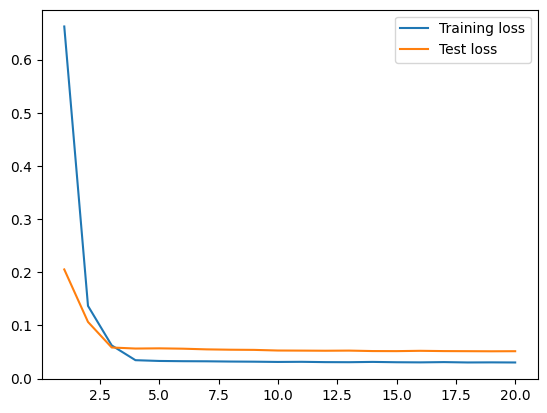

In [ ]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()
